# Расчёт коэффициента $\alpha$ для азота

$$
    \gamma = \frac{1}{4} \frac{{c_r'}^2 - c_r^2}{H_r}
$$

где H_r -- полная энергия без учёта кинетической энергии движения центра масс.

In [1]:
from analys.energy import Staticstics
import numpy as np
import pandas as pd
from tqdm import tqdm
from analys.molecular_system import molecular_system
import matplotlib.pyplot as plt


In [2]:
folder = "1/out_8"
kwargs = {"unstretched" : [0.32932330827068,0.32932330827068],#
"k" : [105734.2419441007825, 105734.72419441007825],
"eps" : 1., "sigma" : 1.}


In [3]:
def process(aiming, num, PATH):
    init = pd.read_csv(PATH + 'aiming_{0}/init/file_{1}.csv'.format(aiming, num), sep='\t',header=None)
    end = pd.read_csv(PATH + 'aiming_{0}/LF/file_{1}.csv'.format(aiming, num), sep='\t',header=None)

    del init[24]
    del end[24]

    init = init[~init.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
    end = end[~end.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
    init, end = to_num(init), to_num(end)
    return init, end

In [4]:
def get_mean_velocity(fixed_df):
    v1 = []
    v2 = []
    for k in range(1,6,2):
        v1.append((fixed_df[k] + fixed_df[k + 6]) / 2)
        v2.append((fixed_df[k + 6 * 2] + fixed_df[k + 6 * 3]) / 2)
    v1 = np.array(v1)
    v2 = np.array(v2)
    return (v1 + v2).T

In [5]:
def to_num(init):
    for i in range(24):
        init[i] = pd.to_numeric(init[i])
    return init

In [6]:
def velocity_length(fixed_df):
    return np.sqrt(np.sum(get_mean_velocity(fixed_df)  * get_mean_velocity(fixed_df), axis = 1))

In [7]:
def angle(fixed_df, fixed_df1):
    return np.sum(get_mean_velocity(fixed_df1) * get_mean_velocity(fixed_df), axis = 1)/(velocity_length(fixed_df1) * velocity_length(fixed_df))

In [8]:
def get_mean_velocity_abs(init): 
    return np.sqrt(np.sum(get_mean_velocity(init) * get_mean_velocity(init), axis = 1))

In [9]:
def calc_params(init, end):
    c_r_i = get_mean_velocity_abs(init)
    c_r_e = get_mean_velocity_abs(end) / c_r_i
    ang = np.abs(angle(init, end)) 
    ang_2 = np.sqrt((1 + ang)/2)
    return ang_2, c_r_e, np.mean(c_r_i)

In [10]:
def alpha(i,e):
    h1 = []
    h2 = []
    c_r1 = []
    c_r2 = []
    for j in xrange(len(i)):
        syst1 = molecular_system(**kwargs)
        syst1.add(np.array(i[j:j+1]).reshape(24))
        syst2 = molecular_system(**kwargs)
        syst2.add(np.array(e[j:j+1]).reshape(24))
        h1.append(syst1.Full_Energy_F()) 
        c_r1.append(syst1.T_Forward_Relative())
        c_r2.append(syst2.T_Forward_Relative())
    
    c_r1 = np.array(c_r1).reshape(len(c_r1))
    c_r2 = np.array(c_r2).reshape(len(c_r2))
    h1 = np.array(h1).reshape(len(h1))
    full_h1 = np.sum(h1)
    return  0.25 * np.sum(c_r2 * c_r2 - c_r1 * c_r1) / full_h1, \
            np.mean(c_r1), \
            0.25 * np.sum(c_r1 * c_r1)/full_h1

In [15]:
def process_full(PATH = "1/out_8/",
                 END_FILE_NUM = 2,
                 START_b = 0.0, 
                 END_b = 2.1, 
                 step_b = 0.2):
    
    result_v = {}
    result_b = {}
    
    for b in tqdm(np.arange(START_b, END_b, step_b)):
        b_in = str(b) + "0" 
    
        for v in range(END_FILE_NUM):
            v_in = str(v)
            init, end = process(b_in, v_in, PATH)
            a,c_r_i, lmbd = alpha(init, end)
            
            c_r_i_str = "%0.1lf"%(c_r_i)
            b_str = "%0.1lf"%(b)
            
            if c_r_i_str not in result_v:
                result_v[c_r_i_str] = {}
                result_v[c_r_i_str]['b'] = []
                result_v[c_r_i_str]['a'] = []                
                result_v[c_r_i_str]['l'] = []
                
            if b_str not in result_b:
                result_b[b_str] = {}
                result_b[b_str]['v'] = []
                result_b[b_str]['a'] = []
                result_b[b_str]['l'] = []
            
            result_v[c_r_i_str]['b'].append(b)
            result_v[c_r_i_str]['a'].append(a)
            result_v[c_r_i_str]['l'].append(lmbd)
            result_b[b_str]['l'].append(lmbd)
            result_b[b_str]['v'].append(c_r_i)
            result_b[b_str]['a'].append(a)
        
    return result_v, result_b

In [16]:
result_v = {}
result_b = {}

v,b = process_full(PATH="out_1887/", 
                       END_FILE_NUM=18,
                 END_b = 4.0, 
                 step_b = 0.3)
result_v.update(v)
result_b.update(b)


100%|██████████| 14/14 [02:24<00:00, 10.32s/it]


# Графики gamma от c_r для разных b

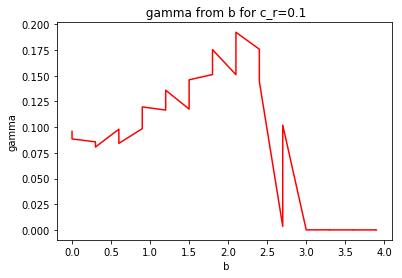

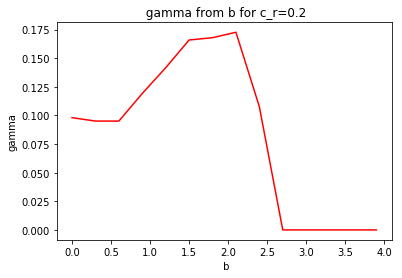

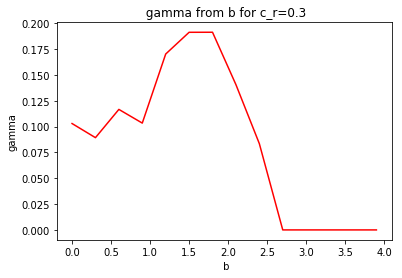

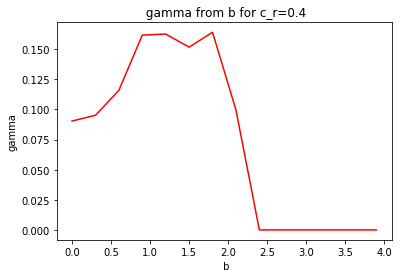

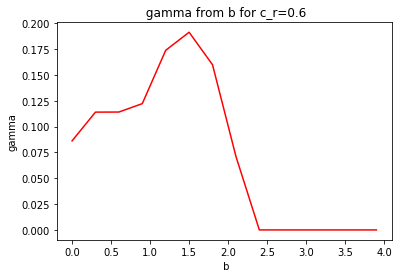

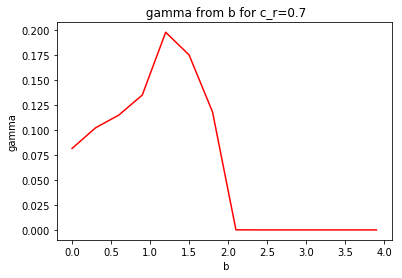

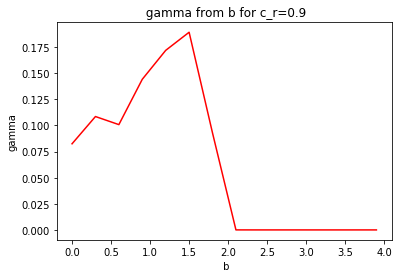

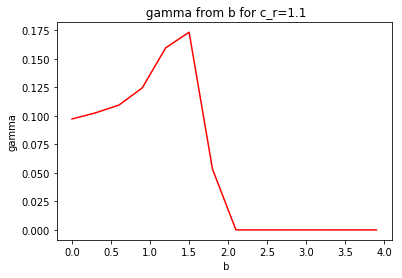

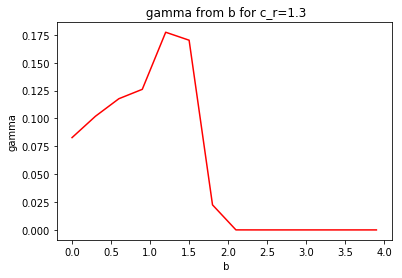

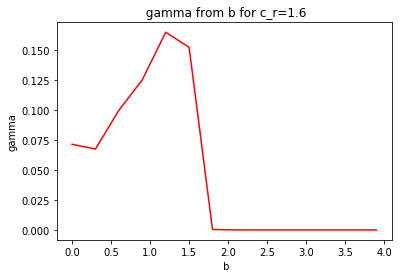

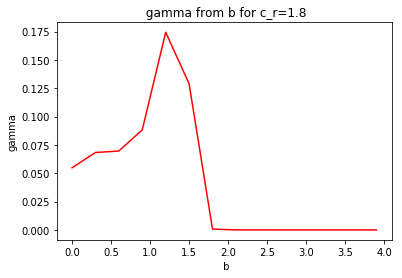

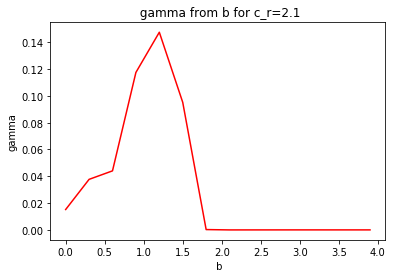

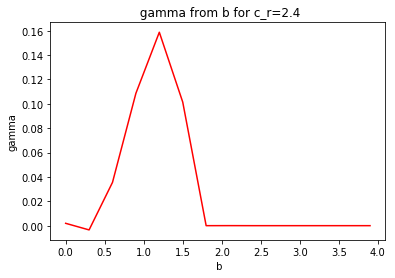

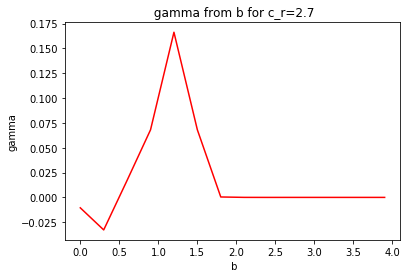

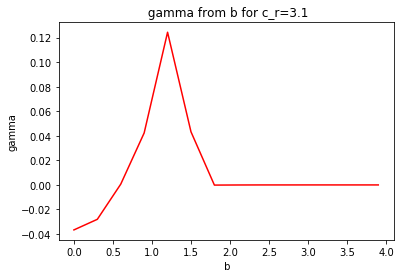

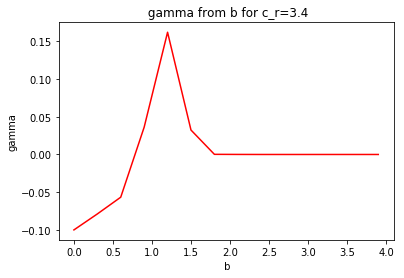

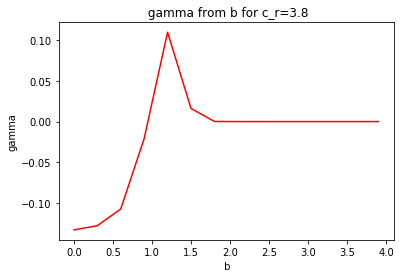

In [25]:
for v in sorted(result_v.keys()):
    plt.plot(result_v[v]['b'],result_v[v]['a'], 'r-')
    plt.xlabel(' b')
    plt.ylabel('gamma')    
    plt.title(' gamma from b for c_r={0}'.format(v))
    plt.show()

# Графики gamma от b для разных c_r

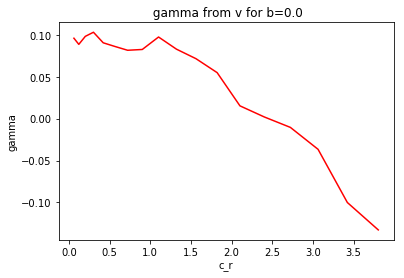

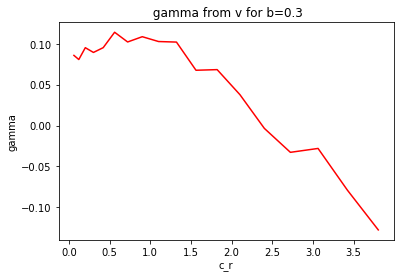

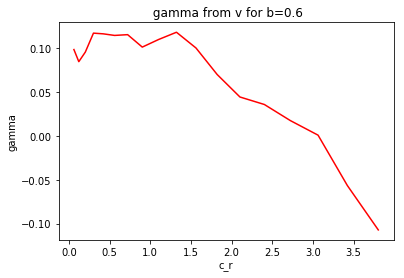

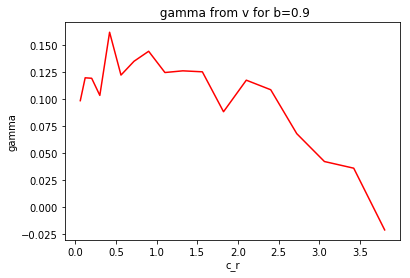

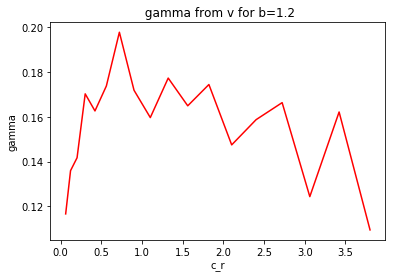

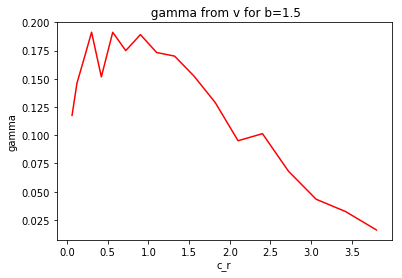

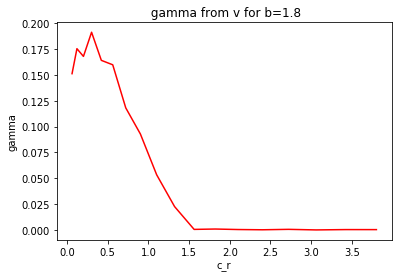

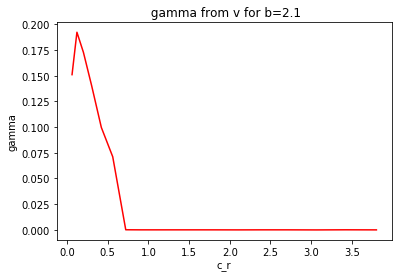

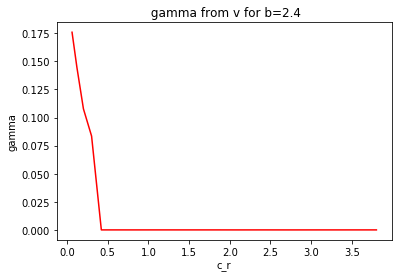

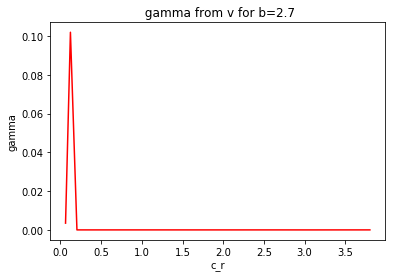

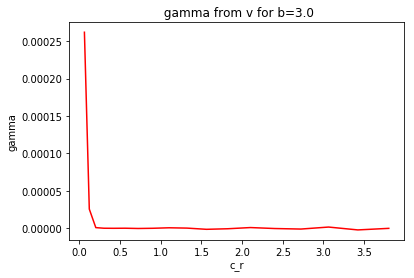

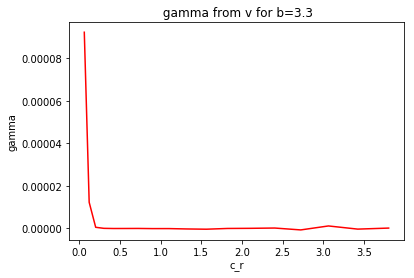

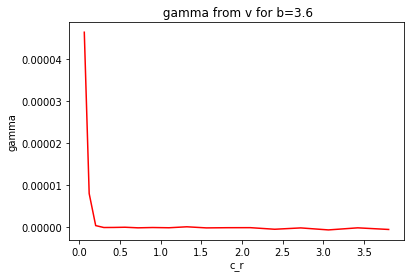

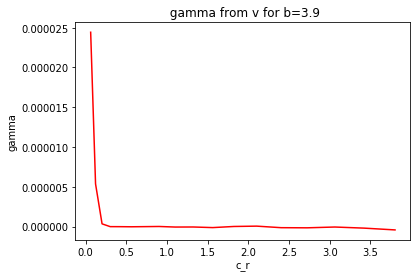

In [18]:
for v in sorted(result_b.keys()):
    plt.plot(result_b[v]['v'],result_b[v]['a'], 'r-')
    plt.xlabel('c_r')
    plt.ylabel('gamma')    
    plt.title(' gamma from c_r for b={0}'.format(v))
    plt.show()

# Графики gamma от lambda для разных b

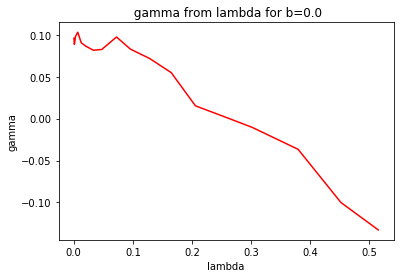

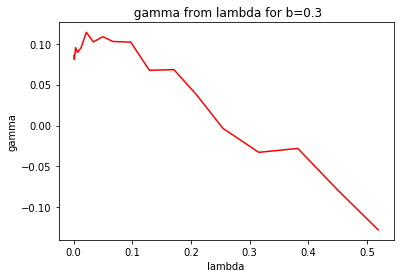

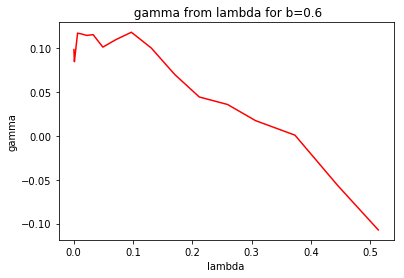

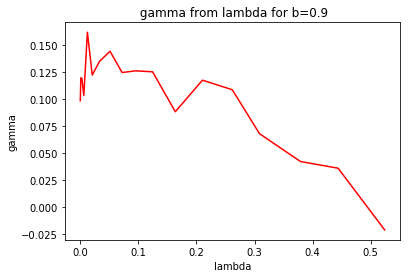

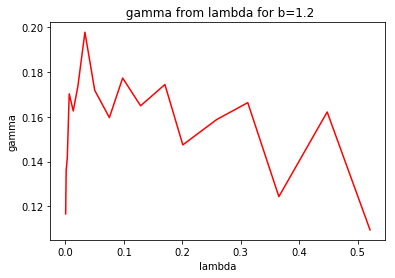

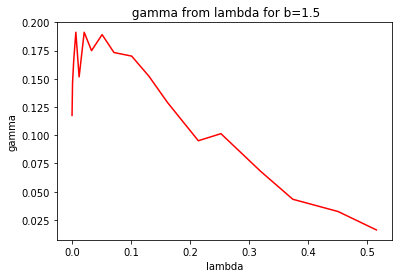

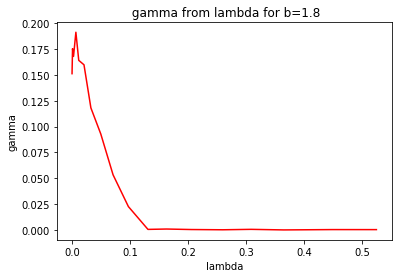

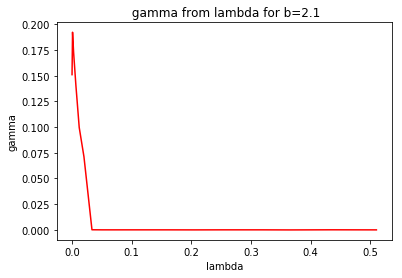

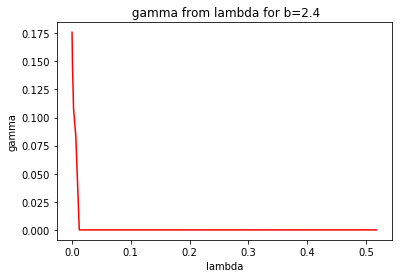

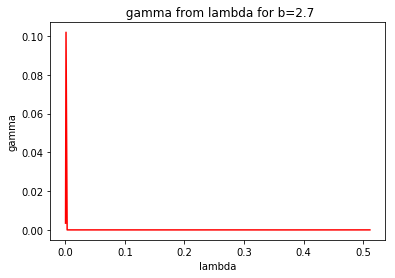

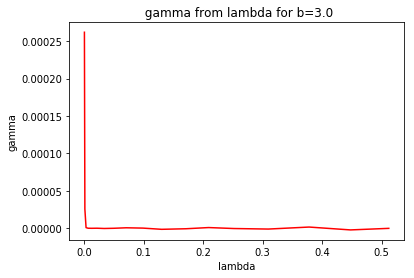

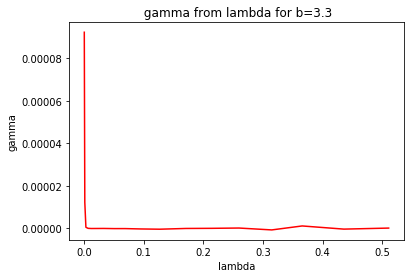

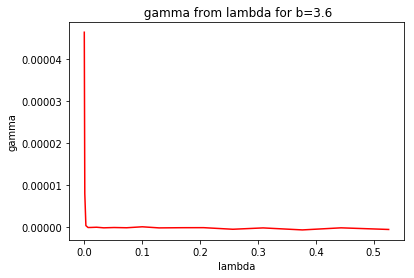

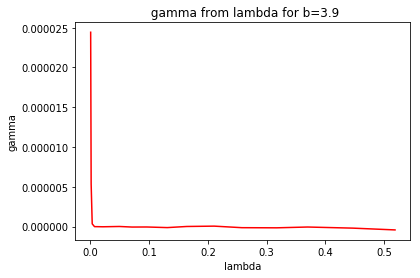

In [21]:
for v in sorted(result_b.keys()):
    plt.plot(result_b[v]['l'],result_b[v]['a'], 'r-')
    plt.xlabel('lambda')
    plt.ylabel('gamma')    
    plt.title(' gamma from lambda for b={0}'.format(v))
    plt.show()

# Графики gamma от lambda для разных c_r

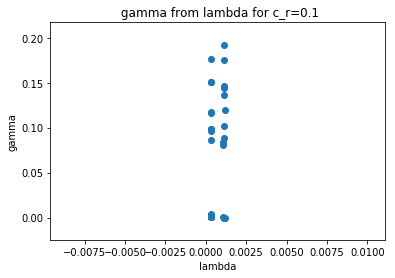

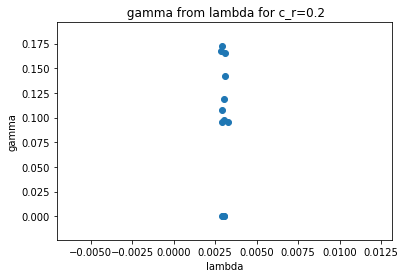

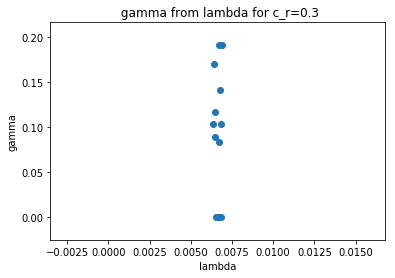

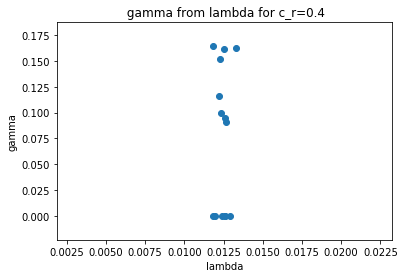

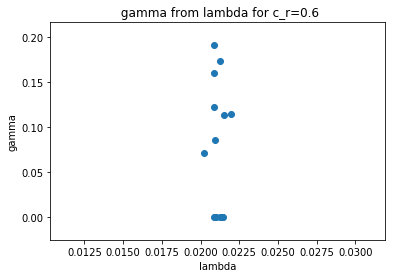

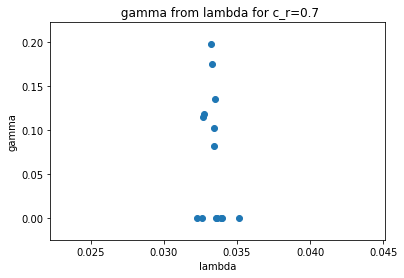

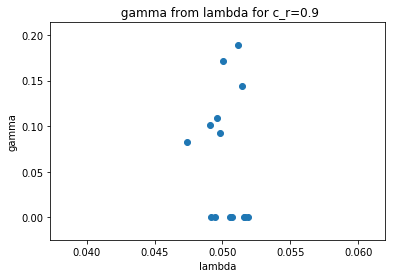

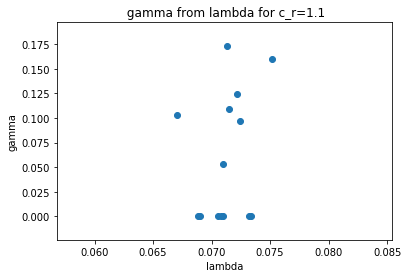

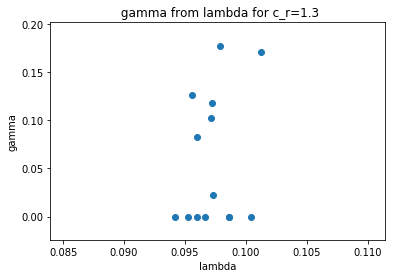

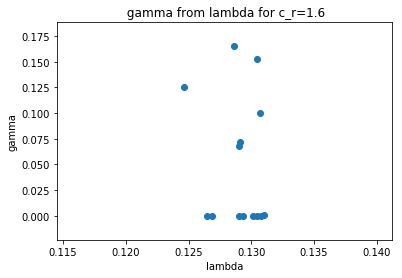

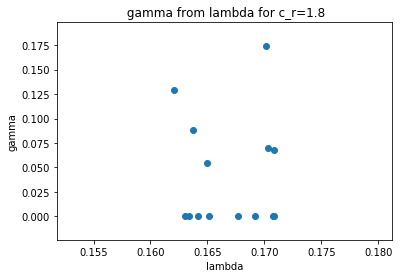

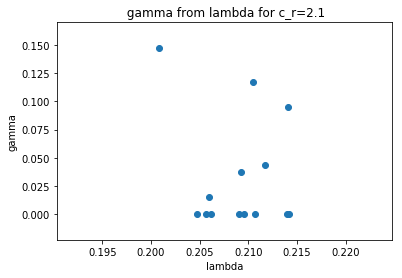

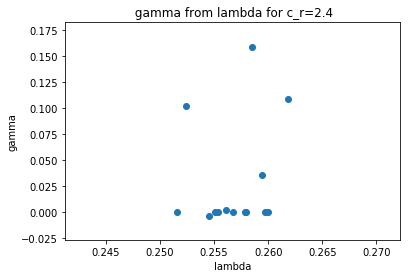

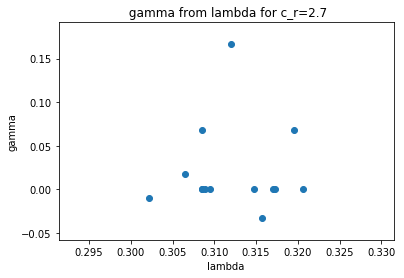

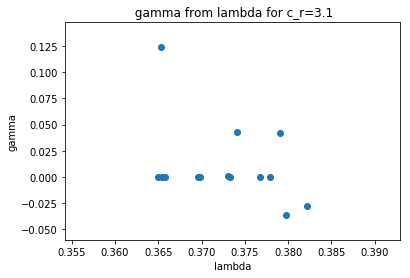

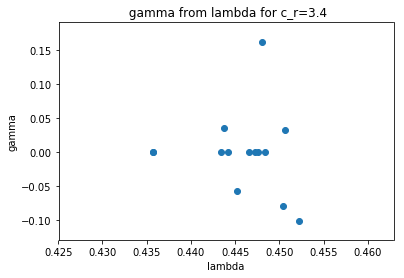

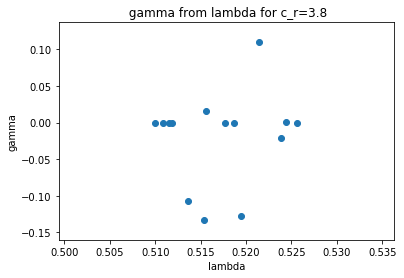

In [24]:
for v in sorted(result_v.keys()):
    plt.scatter(result_v[v]['l'],result_v[v]['a'])
    plt.xlabel('lambda')
    plt.ylabel('gamma')    
    plt.title(' gamma from lambda for c_r={0}'.format(v))
    plt.show()

# Расчёт b_max

Предположим, что $\gamma$ не меняется и почти равен 0, если $\Delta(\gamma) < 1e-3$

In [100]:
b_max = []
c_r = []
for i in sorted(result_v.keys()):
    for j, el in enumerate(np.abs(np.array(result_v[i]['a']))[::-1]):
        if el > 1e-3:
            break
    b_max.append( result_v[i]['b'][-j])
    c_r.append(float(i))
   

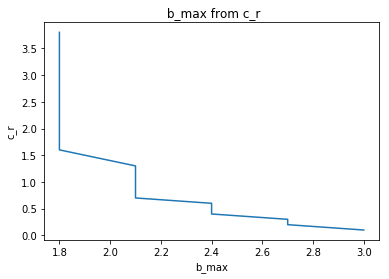

In [103]:
plt.plot(b_max, c_r)
plt.xlabel('b_max')
plt.ylabel('c_r')    
plt.title(' b_max from c_r')
plt.show()

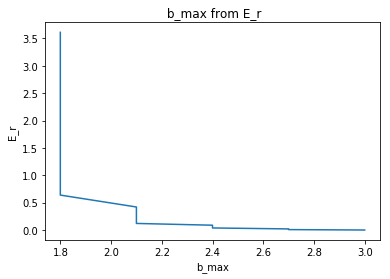

In [106]:
plt.plot(b_max, 0.25 * np.array(c_r)* np.array(c_r))
plt.xlabel('b_max')
plt.ylabel('E_r')    
plt.title(' b_max from E_r')
plt.show()